In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [56.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS9_K265_DinhVietHa/LDS9_K265_DinhVietHa_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K265_DinhVietHa/LDS9_K265_DinhVietHa_Cuoi_ky


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
from pyspark.sql.types import StructType,DoubleType,StringType,IntegerType

In [ ]:
spark = SparkSession.builder.appName('Women_clothing').getOrCreate()

In [ ]:
data = pd.read_excel("./Du lieu cung cap/womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx",\
                     header = 0, index_col=0, sheet_name="Reviews")   

In [ ]:
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
yourSchema = StructType()\
                .add("Clothing ID",  IntegerType(), True)\
                .add("Age",  IntegerType(), True)\
                .add("Title", StringType(), True)\
                .add("Review Text", StringType(), True)\
                .add("Rating",   IntegerType(), True)\
                .add("Recommended IND",  IntegerType(), True)\
                .add("Positive Feedback Count",  IntegerType(), True)\
                .add("Division Name", StringType(), True)\
                .add("Department Name", StringType(), True)\
                .add("Class Name", StringType(), True)\

## Load Data

In [ ]:
df = spark.createDataFrame(data,schema=yourSchema)

In [ ]:
df.show(10)

+-----------+---+--------------------+--------------------+------+---------------+-----------------------+--------------+---------------+----------+
|Clothing ID|Age|               Title|         Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|
+-----------+---+--------------------+--------------------+------+---------------+-----------------------+--------------+---------------+----------+
|        767| 33|                 NaN|Absolutely wonder...|     4|              1|                      0|     Initmates|       Intimate| Intimates|
|       1080| 34|                 NaN|Love this dress! ...|     5|              1|                      4|       General|        Dresses|   Dresses|
|       1077| 60|Some major design...|I had such high h...|     3|              0|                      0|       General|        Dresses|   Dresses|
|       1049| 50|    My favorite buy!|I love, love, lov...|     5|              1|                      0|

In [ ]:
df.printSchema()

root
 |-- Clothing ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [ ]:
df.count()

23481

In [ ]:
df.describe().toPandas()

,summary,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,count,23481,23481,23481,23481,23481,23481,23481,23481,23481,23481
1,mean,918.108641028917,43.19837315276181,NaN,NaN,4.196286359184021,0.8224521953920191,2.5353690217622757,NaN,NaN,NaN
2,stddev,203.31464963720913,12.279291680205576,NaN,NaN,1.109819808465497,0.38213976604340627,5.70212786438075,NaN,NaN,NaN
3,min,0,18,"""beach business""","""does this sweater make my hips look big?"" my ...",1,0,0,General,Bottoms,Blouses
4,max,1205,99,~~so very retailer~~,"Yummy, soft material, but very faded looking. ...",5,1,122,NaN,Trend,Trend


Based on the description above, there are null values in Review Text, Title, Devision Name, Department Name and Class Name.

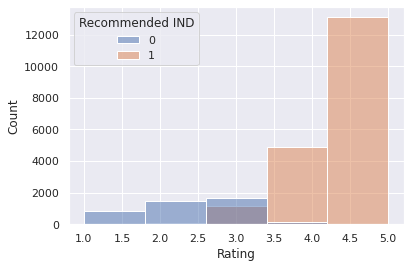

In [ ]:
sns.set(style="darkgrid")

sns.histplot(data = data,
             x = 'Rating',
             color = 'navy',
             bins=5,
             hue='Recommended IND')

plt.show()

Customers who give high rating tend to recommend the products.

--> Recommended IND is highly related to Rating.

## Clean and prepare data

Choose feature "Review Text" and "Recommended IND" to predict "Rating" 

In [ ]:
df_select = df.select("Title","Review Text", "Rating", "Recommended IND")

Create a new length feature

In [ ]:
from pyspark.sql.functions import length

In [ ]:
df_select = df_select.withColumn("length_review", length(df['Review Text']))\
                    .withColumn("length_title", length(df['title']))

In [ ]:
df_select.show(10)

+--------------------+--------------------+------+---------------+-------------+------------+
|               Title|         Review Text|Rating|Recommended IND|length_review|length_title|
+--------------------+--------------------+------+---------------+-------------+------------+
|                 NaN|Absolutely wonder...|     4|              1|           53|           3|
|                 NaN|Love this dress! ...|     5|              1|          303|           3|
|Some major design...|I had such high h...|     3|              0|          500|          23|
|    My favorite buy!|I love, love, lov...|     5|              1|          124|          16|
|    Flattering shirt|This shirt is ver...|     5|              1|          192|          16|
|Not for the very ...|I love tracy rees...|     2|              0|          488|          23|
|Cagrcoal shimmer fun|I aded this in my...|     5|              1|          496|          20|
|Shimmer, surprisi...|I ordered this in...|     4|          

In [ ]:
df_select.groupby("Rating").mean().show()

+------+-----------+--------------------+------------------+-----------------+
|Rating|avg(Rating)|avg(Recommended IND)|avg(length_review)|avg(length_title)|
+------+-----------+--------------------+------------------+-----------------+
|     1|        1.0|0.019024970273483946| 296.5029726516052|16.16052318668252|
|     3|        3.0|  0.4142857142857143|322.00104529616726|18.36376306620209|
|     5|        5.0|  0.9980959634424981| 284.8858339680122|15.51058644325971|
|     4|        4.0|   0.966903073286052|311.76063829787233|17.47340425531915|
|     2|        2.0| 0.06010230179028133|315.37659846547314| 18.1809462915601|
+------+-----------+--------------------+------------------+-----------------+



There is not much difference in length of Review Text between ratings 1-5.

In [ ]:
df_select.groupby("Rating").count().show()

+------+-----+
|Rating|count|
+------+-----+
|     1|  841|
|     3| 2870|
|     5|13130|
|     4| 5076|
|     2| 1564|
+------+-----+



##### Check and drop null rows

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import isnan, when, count

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14
Class Name,14


There is NaN data.

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
Clothing ID,0
Age,0
Title,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,0
Department Name,0
Class Name,0


There are null values in Title, Review Text, Division Name, Department Name and Class Name

Delete null values in Review Text in df_select

In [ ]:
df_select = df_select.filter(df_select["Review Text"] != "NaN")
df_select = df_select.filter(df_select["Title"] != "NaN")

In [ ]:
df_select.select([count(when(isnan(c), c)).alias(c) for c in df_select.columns]).toPandas().T

,0
Title,0
Review Text,0
Rating,0
Recommended IND,0
length_review,0
length_title,0


--> no more null values in Review Text

Since length is not valuable, drop the "length".

In [ ]:
df_select = df_select.select("Review Text","Rating","Recommended IND")

In [ ]:
df_select.show(10)

+--------------------+------+---------------+
|         Review Text|Rating|Recommended IND|
+--------------------+------+---------------+
|I had such high h...|     3|              0|
|I love, love, lov...|     5|              1|
|This shirt is ver...|     5|              1|
|I love tracy rees...|     2|              0|
|I aded this in my...|     5|              1|
|I ordered this in...|     4|              1|
|I love this dress...|     5|              1|
|I'm 5"5' and 125 ...|     5|              1|
|More and more i f...|     5|              1|
|Bought the black ...|     5|              1|
+--------------------+------+---------------+
only showing top 10 rows



In [ ]:
df_select.count()

19670

### Feature Transformation

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tokenizer = Tokenizer(inputCol="Review Text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol="token_text", outputCol="stop_tokens",stopWords=sw)
count_vec = CountVectorizer(inputCol="stop_tokens", outputCol="c_vec", minDF=0.01,maxDF=0.5)
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
class_to_num = StringIndexer(inputCol="Rating", outputCol="label")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

In [ ]:
clean_up = VectorAssembler(inputCols=["tf_idf","Recommended IND"], outputCol="features")

## The Model

First I will try with the Naive Bayes. 

In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
nb = NaiveBayes()

## Pipeline

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
data_prep_pipe = Pipeline(stages = [class_to_num,tokenizer,
                                   stopremove,count_vec,idf,clean_up])

In [ ]:
cleaner = data_prep_pipe.fit(df_select)

In [ ]:
clean_data = cleaner.transform(df_select)

## Training and Evaluation

In [ ]:
clean_data.show(5)

+--------------------+------+---------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Review Text|Rating|Recommended IND|label|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+--------------------+------+---------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|I had such high h...|     3|              0|  2.0|[i, had, such, hi...|[high, hopes, dre...|(535,[2,5,8,11,13...|(535,[2,5,8,11,13...|(536,[2,5,8,11,13...|
|I love, love, lov...|     5|              1|  0.0|[i, love,, love,,...|[love,, love,, lo...|(535,[1,6,10,42,1...|(535,[1,6,10,42,1...|(536,[1,6,10,42,1...|
|This shirt is ver...|     5|              1|  0.0|[this, shirt, is,...|[shirt, flatterin...|(535,[1,6,25,37,3...|(535,[1,6,25,37,3...|(536,[1,6,25,37,3...|
|I love tracy rees...|     2|              0|  3.0|[i, lov

In [ ]:
clean_data = clean_data.select(["label","features"])

In [ ]:
clean_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  2.0|(536,[2,5,8,11,13...|
|  0.0|(536,[1,6,10,42,1...|
|  0.0|(536,[1,6,25,37,3...|
|  3.0|(536,[1,2,6,9,16,...|
|  0.0|(536,[3,4,9,11,14...|
|  1.0|(536,[8,11,13,16,...|
|  0.0|(536,[1,13,14,38,...|
|  0.0|(536,[1,2,5,6,7,1...|
|  0.0|(536,[2,9,12,33,3...|
|  0.0|(536,[0,2,5,7,9,2...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
(training, testing) = clean_data.randomSplit([0.7,0.3])

In [ ]:
training.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7619|
|  1.0| 2930|
|  4.0|  483|
|  3.0|  944|
|  2.0| 1689|
+-----+-----+



In [ ]:
testing.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 3251|
|  1.0| 1358|
|  4.0|  207|
|  3.0|  415|
|  2.0|  774|
+-----+-----+



In [ ]:
predictor = nb.fit(training)

In [ ]:
df_select.printSchema()

root
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)



In [ ]:
test_results = predictor.transform(testing) 

In [ ]:
test_results.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(536,[0,1,2,3,4,6...|[-401.55523108595...|[0.00591176824604...|       1.0|
|  0.0|(536,[0,1,2,3,5,1...|[-517.38341987761...|[0.21464128602685...|       2.0|
|  0.0|(536,[0,1,2,3,7,1...|[-257.38266967495...|[0.58767951884047...|       0.0|
|  0.0|(536,[0,1,2,4,7,8...|[-390.72683988978...|[0.02362631830157...|       1.0|
|  0.0|(536,[0,1,2,5,15,...|[-281.32144472983...|[0.73675289487476...|       0.0|
|  0.0|(536,[0,1,2,5,25,...|[-118.95136739080...|[0.80301357402978...|       0.0|
|  0.0|(536,[0,1,2,6,24,...|[-545.74710512906...|[0.06829869447301...|       2.0|
|  0.0|(536,[0,1,2,7,8,2...|[-330.52216812339...|[0.87582494473219...|       0.0|
|  0.0|(536,[0,1,2,8,9,1...|[-548.36874795700...|[4.88062678897500...|       2.0|
|  0.0|(536,[0,1

Create a confusion matrix

In [ ]:
test_results.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   77|
|  1.0|       1.0|  484|
|  3.0|       2.0|  125|
|  4.0|       2.0|   23|
|  0.0|       1.0|  548|
|  0.0|       4.0|   35|
|  1.0|       0.0|  550|
|  2.0|       2.0|  305|
|  3.0|       1.0|   37|
|  2.0|       3.0|  143|
|  1.0|       4.0|   27|
|  4.0|       4.0|   74|
|  2.0|       4.0|   96|
|  3.0|       4.0|   88|
|  2.0|       1.0|  153|
|  1.0|       2.0|  228|
|  0.0|       0.0| 2469|
|  1.0|       3.0|   69|
|  4.0|       3.0|   66|
|  0.0|       2.0|  165|
+-----+----------+-----+
only showing top 20 rows



Evaluate the model

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
acc_val = MulticlassClassificationEvaluator()
acc = acc_val.evaluate(test_results)
print("Accuracy of model at predicting: {}".format(acc))

Accuracy of model at predicting: 0.5802976316407086


This accuracy of the Naive Bayes model is not good (58%).
--> Try other model

### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(labelCol="label",\
                           featuresCol="features",\
                           numTrees=500,\
                           maxDepth=5,\
                           maxBins=64)

In [ ]:
predictor_1 = rf.fit(training)

In [ ]:
test_results_1 = predictor_1.transform(testing)

In [ ]:
test_results_1.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  774|
|  1.0|       0.0| 1358|
|  0.0|       0.0| 3251|
|  4.0|       0.0|  207|
|  3.0|       0.0|  415|
+-----+----------+-----+



In [ ]:
test_results_1.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6005|
+----------+-----+



In [ ]:
acc_val = MulticlassClassificationEvaluator()
acc_1 = acc_val.evaluate(test_results_1)
print("Accuracy of model at predicting: {}".format(acc_1))

Accuracy of model at predicting: 0.380301095960799


The Random Forest model returns an even lower accuracy than Naive Bayes.
--> Random Forest is not suitable to this problem.

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lg = LogisticRegression(maxIter=20,regParam=0.3,elasticNetParam=0)

In [ ]:
predictor_2 = lg.fit(training)

In [ ]:
test_results_2 = predictor_2.transform(testing)

In [ ]:
test_results_2.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  350|
|  1.0|       1.0|  212|
|  3.0|       2.0|  270|
|  4.0|       2.0|  110|
|  0.0|       1.0|  101|
|  1.0|       0.0| 1105|
|  2.0|       2.0|  307|
|  3.0|       1.0|   19|
|  2.0|       3.0|    6|
|  4.0|       4.0|    1|
|  3.0|       4.0|    1|
|  2.0|       1.0|  111|
|  1.0|       2.0|   41|
|  0.0|       0.0| 3150|
|  4.0|       3.0|   13|
|  4.0|       0.0|   81|
|  3.0|       3.0|    5|
|  3.0|       0.0|  120|
|  4.0|       1.0|    2|
+-----+----------+-----+



The table shows that class 1.0 (rating 4.0) is most wrongly identified as class 0.0 (rating 5.0), followed by class 2.0 (rating 3.0). 

In [ ]:
test_results_2.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 4806|
|       1.0|  445|
|       4.0|    2|
|       3.0|   24|
|       2.0|  728|
+----------+-----+



In [ ]:
acc_val = MulticlassClassificationEvaluator()
acc_2 = acc_val.evaluate(test_results_2)
print("Accuracy of model at predicting: {}".format(acc_2))

Accuracy of model at predicting: 0.5310972317161488


The accuracy does not increase considerably by changing models. On the other hand, the predictions of the 3 models seem to fall to class 0 (rating = 5). This occurs because the number of sample of rating 5 is large compared to others. 

--> re-sample the data

## Resample the data

In [ ]:
rate5_df = training.filter(col("label") == 0)
rate4_df = training.filter(col("label") == 1)
rate3_df = training.filter(col("label") == 2)
rate2_df = training.filter(col("label") == 3)
rate1_df = training.filter(col("label") == 4)

In [ ]:
ratio_1 = int(rate5_df.count()/rate1_df.count())
ratio_2 = int(rate5_df.count()/rate2_df.count())
ratio_3 = int(rate5_df.count()/rate3_df.count())
ratio_4 = int(rate5_df.count()/rate4_df.count())

In [ ]:
for ratio in [ratio_1, ratio_2, ratio_3, ratio_4]:
    print(ratio)

15
8
4
2


#### Resample rating 4.0

In [ ]:
from pyspark.sql.functions import explode, lit,array

In [ ]:
a1 = range(ratio_4)

In [ ]:
oversampled_rate4_df = rate4_df.withColumn("dummy", explode(array([lit(x) for x in a1]))).drop("dummy")

In [ ]:
combined_df = rate5_df.unionAll(oversampled_rate4_df)

In [ ]:
combined_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(536,[0,1,2,3,4,5...|
|  0.0|(536,[0,1,2,3,4,6...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,1...|
|  0.0|(536,[0,1,2,3,5,9...|
|  0.0|(536,[0,1,2,3,5,1...|
|  0.0|(536,[0,1,2,3,6,1...|
|  0.0|(536,[0,1,2,3,7,1...|
|  0.0|(536,[0,1,2,3,7,1...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7619|
|  1.0| 5860|
+-----+-----+



#### Resample rating 3.0

In [ ]:
a2 = range(ratio_3)

In [ ]:
oversampled_rate3_df = rate3_df.withColumn("dummy", explode(array([lit(x) for x in a2]))).drop("dummy")

In [ ]:
combined_df = combined_df.unionAll(oversampled_rate3_df)

In [ ]:
combined_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(536,[0,1,2,3,4,5...|
|  0.0|(536,[0,1,2,3,4,6...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,1...|
|  0.0|(536,[0,1,2,3,5,9...|
|  0.0|(536,[0,1,2,3,5,1...|
|  0.0|(536,[0,1,2,3,6,1...|
|  0.0|(536,[0,1,2,3,7,1...|
|  0.0|(536,[0,1,2,3,7,1...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7619|
|  1.0| 5860|
|  2.0| 6756|
+-----+-----+



#### Resample rating 2.0

In [ ]:
a3 = range(ratio_2)

In [ ]:
oversampled_rate2_df = rate2_df.withColumn("dummy", explode(array([lit(x) for x in a3]))).drop("dummy")

In [ ]:
combined_df = combined_df.unionAll(oversampled_rate2_df)

In [ ]:
combined_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(536,[0,1,2,3,4,5...|
|  0.0|(536,[0,1,2,3,4,6...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,1...|
|  0.0|(536,[0,1,2,3,5,9...|
|  0.0|(536,[0,1,2,3,5,1...|
|  0.0|(536,[0,1,2,3,6,1...|
|  0.0|(536,[0,1,2,3,7,1...|
|  0.0|(536,[0,1,2,3,7,1...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7619|
|  1.0| 5860|
|  3.0| 7552|
|  2.0| 6756|
+-----+-----+



#### Resample rating 1.0

In [ ]:
a4 = range(ratio_1)

In [ ]:
oversampled_rate1_df = rate1_df.withColumn("dummy", explode(array([lit(x) for x in a4]))).drop("dummy")

In [ ]:
combined_df = combined_df.unionAll(oversampled_rate1_df)

In [ ]:
combined_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(536,[0,1,2,3,4,5...|
|  0.0|(536,[0,1,2,3,4,6...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,7...|
|  0.0|(536,[0,1,2,3,4,1...|
|  0.0|(536,[0,1,2,3,5,9...|
|  0.0|(536,[0,1,2,3,5,1...|
|  0.0|(536,[0,1,2,3,6,1...|
|  0.0|(536,[0,1,2,3,7,1...|
|  0.0|(536,[0,1,2,3,7,1...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7619|
|  1.0| 5860|
|  4.0| 7245|
|  3.0| 7552|
|  2.0| 6756|
+-----+-----+



## Naive Bayes (after resampling)

In [ ]:
predictor_3 = nb.fit(combined_df)

In [ ]:
test_results_3 = predictor_3.transform(testing)

In [ ]:
test_results_3.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   58|
|  1.0|       1.0|  481|
|  3.0|       2.0|  122|
|  4.0|       2.0|   17|
|  0.0|       1.0|  586|
|  0.0|       4.0|   55|
|  1.0|       0.0|  494|
|  2.0|       2.0|  287|
|  3.0|       1.0|   26|
|  2.0|       3.0|  178|
|  1.0|       4.0|   35|
|  4.0|       4.0|   85|
|  2.0|       4.0|  116|
|  3.0|       4.0|  109|
|  2.0|       1.0|  135|
|  1.0|       2.0|  256|
|  0.0|       0.0| 2342|
|  1.0|       3.0|   92|
|  4.0|       3.0|   73|
|  0.0|       2.0|  198|
+-----+----------+-----+
only showing top 20 rows



In [ ]:
acc_3 = acc_val.evaluate(test_results_3)
print("Accuracy of model at predicting: {}".format(acc_3))

Accuracy of model at predicting: 0.5659307987523532


## Logistic Regression (after resampling)

In [ ]:
predictor_4 = lg.fit(combined_df)

In [ ]:
test_results_4 = predictor_4.transform(testing)

In [ ]:
acc_4 = acc_val.evaluate(test_results_4)
print("Accuracy of model at predicting: {}".format(acc_4))

Accuracy of model at predicting: 0.5890298480428344


#### Note:

* The accuracy increase from 58% to 59% after resampling. This change is not significant. --> need to work on more improvision.

# Make new prediction in new_reviews sheet

In [ ]:
data_new = pd.read_excel("./Du lieu cung cap/womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx",\
                     header = 0, index_col=0, sheet_name="new_reviews")   

In [ ]:
data_new.head()

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,0,14,General,Dresses,Dresses
1,862,66,Cute top,Nice top. armholes are a bit oversized but as ...,1,2,General,Tops,Knits
2,1080,31,Underwhelmed,Was really excited for this dress but should h...,0,1,General,Dresses,Dresses
3,936,35,Absolutely perfect,If you are going for a ridiculously high price...,0,9,General,Tops,Sweaters
4,872,35,Cute comfy casual,I saw this online and immediately purchased th...,1,0,General,Tops,Knits


In [ ]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              5 non-null      int64 
 1   Age                      5 non-null      int64 
 2   Title                    5 non-null      object
 3   Review Text              5 non-null      object
 4   Recommended IND          5 non-null      int64 
 5   Positive Feedback Count  5 non-null      int64 
 6   Division Name            5 non-null      object
 7   Department Name          5 non-null      object
 8   Class Name               5 non-null      object
dtypes: int64(4), object(5)
memory usage: 400.0+ bytes


In [ ]:
newSchema = StructType().add("Clothing ID",  IntegerType(), True)\
                .add("Age",  IntegerType(), True)\
                .add("Title", StringType(), True)\
                .add("Review Text", StringType(), True)\
                .add("Recommended IND",  IntegerType(), True)\
                .add("Positive Feedback Count",  IntegerType(), True)\
                .add("Division Name", StringType(), True)\
                .add("Department Name", StringType(), True)\
                .add("Class Name", StringType(), True)\

In [ ]:
df_new = spark.createDataFrame(data_new,schema=newSchema)

In [ ]:
df_new.show()

+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+
|Clothing ID|Age|               Title|         Review Text|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+
|       1077| 53|Dress looks like ...|Dress runs small ...|              0|                     14|      General|        Dresses|   Dresses|
|        862| 66|            Cute top|Nice top. armhole...|              1|                      2|      General|           Tops|     Knits|
|       1080| 31|        Underwhelmed|Was really excite...|              0|                      1|      General|        Dresses|   Dresses|
|        936| 35|  Absolutely perfect|If you are going ...|              0|                      9|      General|           Tops|  Sweaters|
|        872|

In [ ]:
df_new.printSchema()

root
 |-- Clothing ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [ ]:
data_new_pipe = Pipeline(stages = [tokenizer,
                                   stopremove,count_vec,idf,clean_up])

In [ ]:
cleaner_new = data_new_pipe.fit(df_new)

In [ ]:
clean_data_new = cleaner.transform(df_new)

## Predict

In [ ]:
clean_data_new.show(5)

+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Clothing ID|Age|               Title|         Review Text|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       1077| 53|Dress looks like ...|Dress runs small ...|              0|                     14|      General|        Dresses|   Dresses|[dress, runs, sma...|[dress, runs, sma...|(535,[2,8,13,18,2...|(535,[2,8,13,18,2...|(536,[2,8,13,18,2...|
|        862| 66

In [ ]:
clean_data_new = clean_data_new.select(["features"])

In [ ]:
clean_data_new.show(10)

+--------------------+
|            features|
+--------------------+
|(536,[2,8,13,18,2...|
|(536,[7,10,12,15,...|
|(536,[2,9,11,31,3...|
|(536,[4,15,19,40,...|
|(536,[5,8,55,65,7...|
+--------------------+



In [ ]:
pred_results = predictor_4.transform(clean_data_new) 

In [ ]:
pred_results.show(10)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(536,[2,8,13,18,2...|[-1.3104463052020...|[0.03755452527036...|       4.0|
|(536,[7,10,12,15,...|[1.02123768023718...|[0.33204464203019...|       1.0|
|(536,[2,9,11,31,3...|[-1.3282137037360...|[0.03293114465878...|       4.0|
|(536,[4,15,19,40,...|[-0.6525360229591...|[0.08575157711093...|       3.0|
|(536,[5,8,55,65,7...|[1.98708430751079...|[0.72115970484934...|       0.0|
+--------------------+--------------------+--------------------+----------+



# Grouping rating 4-5 to like, 1-2 to not like, 3 to neutral

Since rating 4 and 5 seem to be mixed when classifying, as well as rating 1 and 2, we group the rating into 3 groups.

In [ ]:
df_group = df_select.withColumn("class",when(df_select.Rating >= 4,"like")
                              .when(df_select.Rating <= 2, "not_like")
                              .otherwise("neutral"))

In [ ]:
df_group.show(5)

+--------------------+------+---------------+--------+
|         Review Text|Rating|Recommended IND|   class|
+--------------------+------+---------------+--------+
|I had such high h...|     3|              0| neutral|
|I love, love, lov...|     5|              1|    like|
|This shirt is ver...|     5|              1|    like|
|I love tracy rees...|     2|              0|not_like|
|I aded this in my...|     5|              1|    like|
+--------------------+------+---------------+--------+
only showing top 5 rows



In [ ]:
df_group = df_group.withColumn("length", length(df_group['Review Text']))

In [ ]:
df_group.show(5)

+--------------------+------+---------------+--------+------+
|         Review Text|Rating|Recommended IND|   class|length|
+--------------------+------+---------------+--------+------+
|I had such high h...|     3|              0| neutral|   500|
|I love, love, lov...|     5|              1|    like|   124|
|This shirt is ver...|     5|              1|    like|   192|
|I love tracy rees...|     2|              0|not_like|   488|
|I aded this in my...|     5|              1|    like|   496|
+--------------------+------+---------------+--------+------+
only showing top 5 rows



In [ ]:
df_group.groupby('class').mean().show()

+--------+------------------+--------------------+------------------+
|   class|       avg(Rating)|avg(Recommended IND)|       avg(length)|
+--------+------------------+--------------------+------------------+
|not_like|1.6632503660322109|  0.0424597364568082|322.70571010248904|
| neutral|               3.0| 0.41412911084043846| 336.7324401136825|
|    like| 4.717113075603642|  0.9889827153978097|314.76936271275895|
+--------+------------------+--------------------+------------------+



In [ ]:
df_group.groupby('class').count().show()

+--------+-----+
|   class|count|
+--------+-----+
|not_like| 2049|
| neutral| 2463|
|    like|15158|
+--------+-----+



In [ ]:
group_to_num = StringIndexer(inputCol="class", outputCol="label")

In [ ]:
group_prep_pipe = Pipeline(stages=[group_to_num, tokenizer, stopremove, count_vec, idf, clean_up])

In [ ]:
cleaner_gr = group_prep_pipe.fit(df_group)

In [ ]:
clean_data_gr = cleaner_gr.transform(df_group)

In [ ]:
clean_data_gr.show(5)

+--------------------+------+---------------+--------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Review Text|Rating|Recommended IND|   class|length|label|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+--------------------+------+---------------+--------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|I had such high h...|     3|              0| neutral|   500|  1.0|[i, had, such, hi...|[high, hopes, dre...|(535,[2,5,8,11,13...|(535,[2,5,8,11,13...|(536,[2,5,8,11,13...|
|I love, love, lov...|     5|              1|    like|   124|  0.0|[i, love,, love,,...|[love,, love,, lo...|(535,[1,6,10,42,1...|(535,[1,6,10,42,1...|(536,[1,6,10,42,1...|
|This shirt is ver...|     5|              1|    like|   192|  0.0|[this, shirt, is,...|[shirt, flatterin...|(535,[1,6,25,37,3...|(535,

In [ ]:
clean_data_gr = clean_data_gr.select(['label','features'])

In [ ]:
(training_gr, testing_gr) = clean_data_gr.randomSplit([0.7,0.3])

In [ ]:
predictor_5 = nb.fit(training_gr)

In [ ]:
test_results_5 = predictor_5.transform(testing_gr)

In [ ]:
test_results_5.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  107|
|  1.0|       1.0|  348|
|  0.0|       1.0|  630|
|  1.0|       0.0|  156|
|  2.0|       2.0|  311|
|  2.0|       1.0|  183|
|  1.0|       2.0|  196|
|  0.0|       0.0| 3840|
|  0.0|       2.0|  156|
+-----+----------+-----+



In [ ]:
acc_5 = acc_val.evaluate(test_results_5)
print("Accuracy of model at predicting: {}".format(acc_5))

Accuracy of model at predicting: 0.7807684244318277


Grouping the ratings does provide a higher accuracy, due to the fact that there are fewer classes.

In [ ]:
predictor_6 = lg.fit(training_gr)

In [ ]:
test_results_6 = predictor_6.transform(testing_gr)

In [ ]:
test_results_6.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  245|
|  1.0|       1.0|  144|
|  0.0|       1.0|   28|
|  1.0|       0.0|  444|
|  2.0|       2.0|  229|
|  2.0|       1.0|  127|
|  1.0|       2.0|  112|
|  0.0|       0.0| 4591|
|  0.0|       2.0|    7|
+-----+----------+-----+



In [ ]:
acc_6 = acc_val.evaluate(test_results_6)
print("Accuracy of model at predicting: {}".format(acc_6))

Accuracy of model at predicting: 0.8064369556664525


The logistic regression model has a higher accuracy here after grouping.

## Predict new_reviews

In [ ]:
clean_data_new_1 = cleaner_gr.transform(df_new)

In [ ]:
clean_data_new_1 = clean_data_new_1.select(["features"])

In [ ]:
clean_data_new_1.show(10)

+--------------------+
|            features|
+--------------------+
|(536,[2,8,13,18,2...|
|(536,[7,10,12,15,...|
|(536,[2,9,11,31,3...|
|(536,[4,15,19,40,...|
|(536,[5,8,55,65,7...|
+--------------------+



In [ ]:
pred_results_1 = predictor_6.transform(clean_data_new_1) 

In [ ]:
pred_results_1.show(10)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(536,[2,8,13,18,2...|[-0.7531313106360...|[0.13374232336506...|       2.0|
|(536,[7,10,12,15,...|[1.97499784168044...|[0.89032509573403...|       0.0|
|(536,[2,9,11,31,3...|[-0.9619320713764...|[0.09785870045748...|       2.0|
|(536,[4,15,19,40,...|[0.03188423618724...|[0.34060633946417...|       2.0|
|(536,[5,8,55,65,7...|[2.61139434127008...|[0.96150612986259...|       0.0|
+--------------------+--------------------+--------------------+----------+



Compare with non-grouping results

In [ ]:
pred_results.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(536,[2,8,13,18,2...|[-1.3104463052020...|[0.03755452527036...|       4.0|
|(536,[7,10,12,15,...|[1.02123768023718...|[0.33204464203019...|       1.0|
|(536,[2,9,11,31,3...|[-1.3282137037360...|[0.03293114465878...|       4.0|
|(536,[4,15,19,40,...|[-0.6525360229591...|[0.08575157711093...|       3.0|
|(536,[5,8,55,65,7...|[1.98708430751079...|[0.72115970484934...|       0.0|
+--------------------+--------------------+--------------------+----------+



non-grouping classes: 0(rate 5), 1(rate 4), 2(rate 3), 3(rate 2), 4(rate 1)
* The resutls are: 4 (rate 1), 1(rate 4), 4(rate 1), 3(rate 2), 0(rate 5)

grouping clases: 0(rate 4-5), 1(rate 3), 2(rate 1-2)
* The results are: 2 (rate 1-2), 0(rate 4-5), 2 (rate 1-2), 2 (rate 1-2), 0(rate 4-5) 

=> Technically the results are similar with or without grouping. If we only care about the overall setiments (like/not like) of a customer, then grouping is a suitable method for predicting sentiments, while fasten the execution.
